In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import pip
pip.main(['install','seaborn'])
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from keras.applications import DenseNet121, VGG19
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, LeakyReLU, GlobalAveragePooling2D, Conv2D, Input
from keras.optimizers import Adam
from keras.losses import BinaryFocalCrossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

modelclass = '5'
suffix = 'FIN'
base_dir = '../../Data/Arrays/unfiltered/'
class_dir = 'Converted Arrays/'

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: seaborn in /opt/conda/lib/python3.11/site-packages (0.13.2)

Requirement already satisfied: numpy!=1.24.0,>=1.20 in /opt/conda/lib/python3.11/site-packages (from seaborn) (1.26.4)

Requirement already satisfied: pandas>=1.2 in /opt/conda/lib/python3.11/site-packages (from seaborn) (2.2.3)

Requirement already satisfied: matplotlib!=3.6.1,>=3.4 in /opt/conda/lib/python3.11/site-packages (from seaborn) (3.9.3)

Requirement already satisfied: contourpy>=1.0.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.3.1)

Requirement already satisfied: cycler>=0.10 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (0.12.1)

Requirement already satisfied: fonttools>=4.22.0 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (4.55.3)

Requirement already satisfied: kiwisolver>=1.3.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.4.7)

Requirement already satisfied: packaging>=20.0 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (24.2)

Requirement already satisfied: pillow>=8 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (10.4.0)

Requirement already satisfied: pyparsing>=2.3.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (3.2.0)

Requirement already satisfied: python-dateutil>=2.7 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (2.9.0.post0)

Requirement already satisfied: pytz>=2020.1 in /opt/conda/lib/python3.11/site-packages (from pandas>=1.2->seaborn) (2023.3)

Requirement already satisfied: tzdata>=2022.7 in /opt/conda/lib/python3.11/site-packages (from pandas>=1.2->seaborn) (2024.2)

Requirement already satisfied: six>=1.5 in /opt/conda/lib/python3.11/site-packages (from python-dateutil>=2.7->matplotlib!=3.6.1,>=3.4->seaborn) (1.17.0)

I0000 00:00:1737134830.436470   11584 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737134830.490166   11584 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737134830.493648   11584 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737134830.497931   11584 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

 2/41 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step

I0000 00:00:1737134848.882914   11652 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

E0000 00:00:1737134860.637488   11651 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737134860.862098   11651 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737134862.317901   11651 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737134862.622063   11651 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 452ms/step


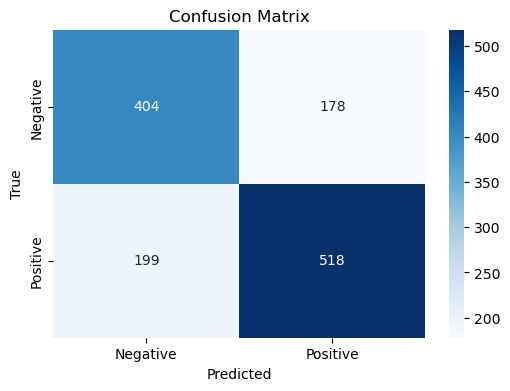

In [2]:
from keras.models import load_model
test_images = np.load(os.path.join(base_dir, 'unfiltered_test_images.npy'))
test_labels = np.load(os.path.join(class_dir, f'test_labels_class{modelclass}.npy'))
test_image_names = np.load(os.path.join(base_dir, 'unfiltered_test_image_names.npy'), allow_pickle=True)
model = load_model('Models/class_FIN5_overallbestFIN.keras')
if len(test_images.shape) == 3:
    test_images = np.expand_dims(test_images, axis=-1)
    test_images = np.repeat(test_images, 3, axis=-1)

# test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)

# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(test_images)
y_pred_binary = (y_pred > 0.5).astype(int)


cm = confusion_matrix(test_labels, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

def display_image_with_predictions(image, image_name, actual_label, predicted_label, likelihood):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Image: {image_name}\nActual: {actual_label}\nPredicted: {predicted_label}\nLikelihood: {likelihood:.4f}")
    plt.axis('off')
    plt.show()

# num_samples = 20
# indices = random.sample(range(test_images.shape[0]), num_samples)

# for idx in indices:
#     image = test_images[idx]
#     image_name = test_image_names[idx]
#     actual_label = test_labels[idx][0]
#     image_expanded = np.expand_dims(image, axis=0)
#     prediction = model.predict(image_expanded)[0][0]
    
#     threshold = 0.5
#     predicted_label = int(prediction > threshold)
#     likelihood = prediction
    
#     display_image_with_predictions(image, image_name, actual_label, predicted_label, likelihood)

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.7001 - loss: 0.1352
Test Loss: 0.13803277909755707
Test Accuracy: 0.704635739326477
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step


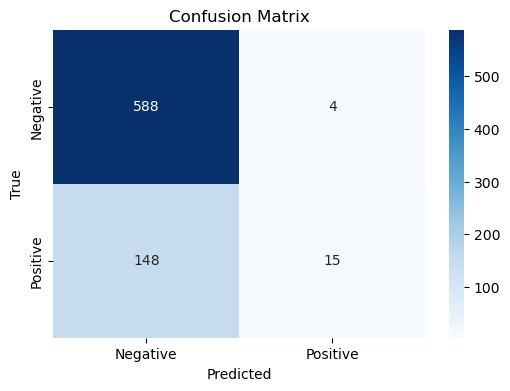

In [5]:
base_dir = '../../Data/Arrays/'
class_dir = '../Label5/Converted Arrays/'
test_images = np.load(os.path.join(base_dir, 'test_images.npy'))
test_labels = np.load(os.path.join(class_dir, f'test_labels_class{modelclass}.npy'))
test_image_names = np.load(os.path.join(base_dir, 'test_image_names.npy'), allow_pickle=True)

if len(test_images.shape) == 3:
    test_images = np.expand_dims(test_images, axis=-1)
    test_images = np.repeat(test_images, 3, axis=-1)

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(test_images)
y_pred_binary = (y_pred > 0.7).astype(int)

cm = confusion_matrix(test_labels, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# def display_image_with_predictions(image, image_name, actual_label, predicted_label, likelihood):
#     plt.imshow(image.squeeze(), cmap='gray')
#     plt.title(f"Image: {image_name}\nActual: {actual_label}\nPredicted: {predicted_label}\nLikelihood: {likelihood:.4f}")
#     plt.axis('off')
#     plt.show()

# num_samples = 20
# indices = random.sample(range(test_images.shape[0]), num_samples)

# for idx in indices:
#     image = test_images[idx]
#     image_name = test_image_names[idx]
#     actual_label = test_labels[idx][0]
#     image_expanded = np.expand_dims(image, axis=0)
#     prediction = model.predict(image_expanded)[0][0]
    
#     threshold = 0.5
#     predicted_label = int(prediction > threshold)
#     likelihood = prediction
    
#     display_image_with_predictions(image, image_name, actual_label, predicted_label, likelihood)